In [67]:
# Note : 
# To run below code, please create separate conda environment and install tensorflow library

#conda create -n tf tensorflow
#conda activate tf

# Import Libraries

In [68]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import seaborn as sns


# Load dataset - Data Science Job Postings from Indeed

In [69]:
# Load the dataset
df = pd.read_csv("./data_science_jobs_indeed_usa.csv", index_col=0)
df.head(5)


,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions
0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You‚Äôll be working alongside a team of eight ...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...
1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...
2,IT Business Intelligence Developer (FT) Remote...,Ballad Health,"Remote in Blountville, TN",3.0,PostedPosted 30+ days ago,NaN,Job Details Apply Save Print this job Email a‚Ä¶,https://www.indeed.com/rc/clk?jk=58612836c63b8...,Job Details\nApply\nSave\nPrint this job\nEmai...
3,Data Engineer,Longevity Holdings Inc.,"Remote in Minneapolis-Saint Paul, MN",NaN,PostedPosted 3 days ago,"$90,000 - $110,000 a year",Incorporate core data management competencies ...,https://www.indeed.com/company/TwentyFirst/job...,Position: Data Engineer\nLocation: MN\nAs a Da...
4,Network Administrator/dba developer,WKI Kenworth,"Wichita, KS 67219",NaN,EmployerActive 2 days ago,"$50,000 - $70,000 a year",The Network Administrator provides 2nd level e...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Full Job Description\nThe Network Administrato...


# Combine columns 'Job Title' and 'Job Description'

In [70]:
df['title_description'] = df['Title'].str.cat(df['Descriptions'], sep=' ').str.lower()

# Preprocess title and description columns

In [71]:
# Group by same job titles and aggregate descriptions
grouped_df = df.groupby('Title').agg({'title_description': ' '.join}).reset_index()

# To generate features using TF-IDF along with stop word removal
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_grouped = vectorizer.fit_transform(grouped_df['title_description']).toarray()

# Scale the data
scaler = MinMaxScaler()
X_scaled_grouped = scaler.fit_transform(X_grouped)

# Neural network autoencoder for dimensionality reduction
input_dim = X_scaled_grouped.shape[1]
encoding_dim = 64

# Encoder network
input_data = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_data)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
autoencoder.fit(X_scaled_grouped, X_scaled_grouped, epochs=100, batch_size=256, shuffle=True)

# Encoder model
encoder = Model(input_data, encoded)

# Encode the input data
X_encoded_grouped = encoder.predict(X_scaled_grouped)


Epoch 1/100
566/566 [==============================] - 1s 2ms/sample - loss: 0.6925
Epoch 2/100
566/566 [==============================] - 0s 529us/sample - loss: 0.6843
Epoch 3/100
566/566 [==============================] - 0s 459us/sample - loss: 0.6526
Epoch 4/100
566/566 [==============================] - 0s 459us/sample - loss: 0.5857
Epoch 5/100
566/566 [==============================] - 0s 467us/sample - loss: 0.4854
Epoch 6/100
566/566 [==============================] - 0s 470us/sample - loss: 0.3677
Epoch 7/100
566/566 [==============================] - 0s 472us/sample - loss: 0.2583
Epoch 8/100
566/566 [==============================] - 0s 439us/sample - loss: 0.1759
Epoch 9/100
566/566 [==============================] - 0s 427us/sample - loss: 0.1251
Epoch 10/100
566/566 [==============================] - 0s 552us/sample - loss: 0.0988
Epoch 11/100
566/566 [==============================] - 0s 690us/sample - loss: 0.0867
Epoch 12/100
566/566 [==============================] 

566/566 [==============================] - 0s 489us/sample - loss: 0.0509
Epoch 96/100
566/566 [==============================] - 0s 481us/sample - loss: 0.0509
Epoch 97/100
566/566 [==============================] - 0s 470us/sample - loss: 0.0508
Epoch 98/100
566/566 [==============================] - 0s 466us/sample - loss: 0.0508
Epoch 99/100
566/566 [==============================] - 0s 472us/sample - loss: 0.0507
Epoch 100/100
566/566 [==============================] - 0s 493us/sample - loss: 0.0507


# Train using clustering algorithms

In [72]:
# Clustering with K-Means
def kmeans_clustering(X, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    return clusters, silhouette_avg

# Clustering with DB-Scan
def dbscan_clustering(X, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    # As silhouette score is only useful if there is more than one grouping and noise points
    if len(set(clusters)) > 1 and -1 in clusters:
        silhouette_avg = silhouette_score(X, clusters)
    else:
        silhouette_avg = None  
    return clusters, silhouette_avg

# Clustering with Agglomerative Clustering
def agglomerative_clustering(X, n_clusters=5):
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = agglomerative.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    return clusters, silhouette_avg


# Train using Neural Network based clustering algorithms

In [73]:

def perform_clustering(X, method='kmeans', n_clusters=5, eps=0.5, min_samples=5):
    if method == 'kmeans':
        return kmeans_clustering(X, n_clusters)
    elif method == 'dbscan':
        return dbscan_clustering(X, eps, min_samples)
    elif method == 'agglomerative':
        return agglomerative_clustering(X, n_clusters)
    else:
        raise ValueError("Unsupported clustering method specified.")

                
def add_clusters_to_df_and_display(grouped_df, X, method='kmeans', n_clusters=5, eps=0.5, min_samples=5):
    clusters, silhouette_avg = perform_clustering(X, method, n_clusters, eps, min_samples)
    method_name = method.upper()
    grouped_df[f'NN_{method_name}_Cluster'] = clusters
    print(f" Neural Network based {method_name} Silhouette Score: {silhouette_avg if silhouette_avg is not None else 'N/A'}")
    print(grouped_df[['Title', f'NN_{method_name}_Cluster']].head())
    print(grouped_df[['Title', f'NN_{method_name}_Cluster']].sort_values(f'NN_{method_name}_Cluster').head())
    return clusters
        


# Compare using Silhouette Score before and after using Neural Network approach

In [74]:

print()
kmeans_clusters, kmeans_silhouette = kmeans_clustering(X_scaled_grouped)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
grouped_df['KMeans_Cluster'] = kmeans_clusters
print()
print(grouped_df[['Title', 'KMeans_Cluster']].head())
print()
print(grouped_df[['Title', 'KMeans_Cluster']].sort_values('KMeans_Cluster').head())
print()

#dbscan_clusters, dbscan_silhouette = dbscan_clustering(X_scaled_grouped)
#print(f"DBSCAN Silhouette Score: {dbscan_silhouette if dbscan_silhouette else 'N/A'}")
#grouped_df['DBSCAN_Cluster'] = dbscan_clusters

print()
agglomerative_clusters, agglomerative_silhouette = agglomerative_clustering(X_scaled_grouped)
print(f"Agglomerative Silhouette Score: {agglomerative_silhouette if agglomerative_silhouette else 'N/A'}")
grouped_df['Agglomerative_Cluster'] = agglomerative_clusters
print()
print(grouped_df[['Title', 'Agglomerative_Cluster']].head())
print()
print(grouped_df[['Title', 'Agglomerative_Cluster']].sort_values('Agglomerative_Cluster').head())
print()

print("~~~~~~~~~`Using Neural Network based clustering algorithms~~~~~~~~~~~~")
print()
# Passing X_encoded_grouped input for neural network based clustering
clusters_grouped_kmeans = add_clusters_to_df_and_display(grouped_df, X_encoded_grouped, 'kmeans', n_clusters=5)
print()
#add_clusters_to_df_and_display(grouped_df, X_encoded_grouped, 'NN dbscan', eps=0.5, min_samples=5)
clusters_grouped_agglomerative = add_clusters_to_df_and_display(grouped_df, X_encoded_grouped, 'agglomerative', n_clusters=5)


K-Means Silhouette Score: -0.07443573552111789

                                               Title  KMeans_Cluster
0  100% Remote! Product Manager- Data Science/Opt...               3
1            AI Data Annotation & Deployment Manager               2
2                  AI Python Developer - Entry level               2
3                        AI and Data Science Manager               2
4  AI/ML - Search Analytics Data Science Manager,...               2

                                                 Title  KMeans_Cluster
302     Entry Level NLP/Data Science Engineer - 333321               0
438                               Python Data Engineer               0
318                    GCP Data Engineer - 100% Remote               0
441  REMOTE JOB || Looking for 10+ Yeas of Data Eng...               0
317                                  GCP Data Engineer               0


Agglomerative Silhouette Score: 0.0030333857107172502

                                               Title 

# Using PCA to reduce features for plotting purpose

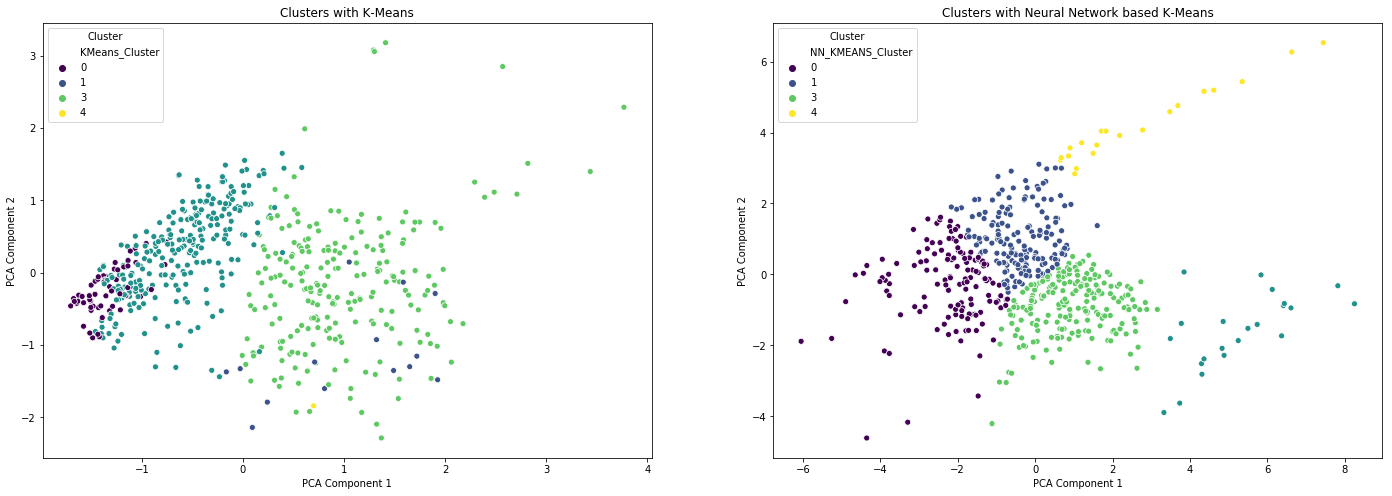

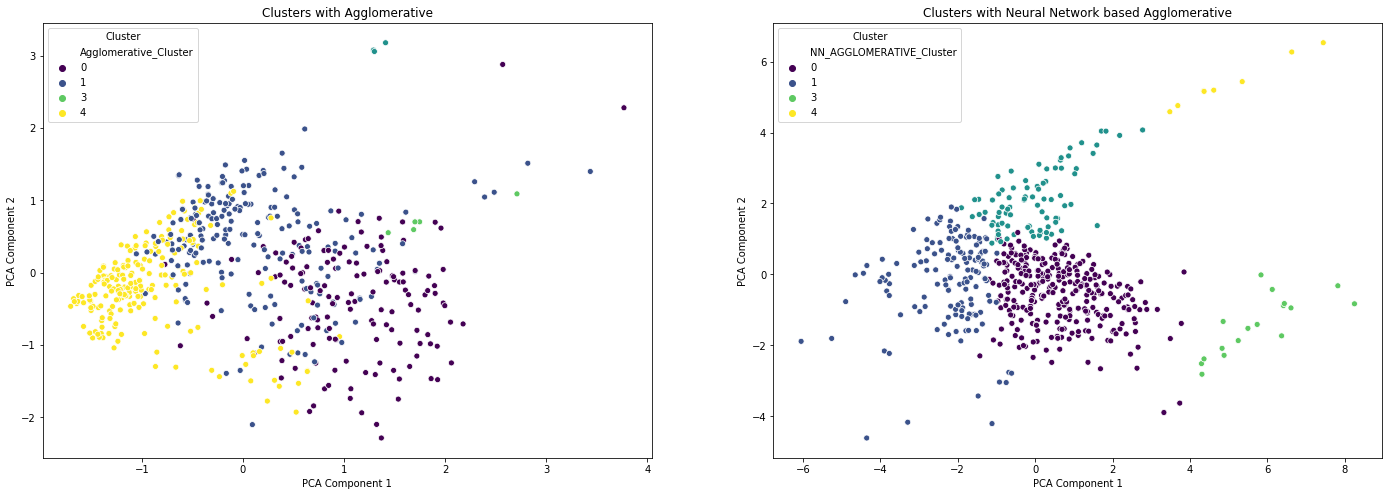

In [75]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pca_transform(X, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X)



# Plotting the clusters
def plot_clusters_side_by_side(X_original, clusters_original, X_encoded, clusters_encoded, title_original, title_encoded):
    # Transform both original and encoded data
    X_pca_original = pca_transform(X_original)
    X_pca_encoded = pca_transform(X_encoded)

    fig, axes = plt.subplots(1, 2, figsize=(24, 8))

    sns.scatterplot(X_pca_original[:, 0], X_pca_original[:, 1], hue=clusters_original, 
                    palette='viridis', ax=axes[0])
    axes[0].set_title(title_original)
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')
    axes[0].legend(title='Cluster')

    # Plot encoded clustering results
    sns.scatterplot(X_pca_encoded[:, 0], X_pca_encoded[:, 1], hue=clusters_encoded, 
                    palette='viridis', ax=axes[1])

    axes[1].set_title(title_encoded)
    axes[1].set_xlabel('PCA Component 1')
    axes[1].set_ylabel('PCA Component 2')
    #axes[1].colorbar().set_label('Cluster')
    axes[1].legend(title='Cluster')
    
    plt.show()


# X_scaled_grouped, clusters -> non NN based
# X_encoded_grouped, clusters_NN -> NN based

# Call the function to plot clusters
plot_clusters_side_by_side(X_scaled_grouped, grouped_df['KMeans_Cluster'], X_encoded_grouped, grouped_df['NN_KMEANS_Cluster'], 'Clusters with K-Means', 'Clusters with Neural Network based K-Means')
plot_clusters_side_by_side(X_scaled_grouped, grouped_df['Agglomerative_Cluster'], X_encoded_grouped, grouped_df['NN_AGGLOMERATIVE_Cluster'], 'Clusters with Agglomerative', 'Clusters with Neural Network based Agglomerative')


# Additional Code 
#Train a model using above clustered data to be able to build a job recommendation engine that provides candidates with alternative job titles they can apply for with respect to the job title of their choice
#Note: I have used a simple model to further test the groupings for accuracy and display a rough code structure of a job recommendation engine

In [76]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


# Prepare the data for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled_grouped, grouped_df['NN_KMEANS_Cluster'], test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Function to predict the cluster of a new job title and suggest similar titles
def predict_and_suggest(job_title):
    processed_title = vectorizer.transform([job_title.lower()]).toarray()
    processed_title_scaled = scaler.transform(processed_title)
    predicted_cluster = model.predict(processed_title_scaled)[0]
    
    similar_titles = grouped_df[grouped_df['NN_KMEANS_Cluster'] == predicted_cluster]['Title'].tolist()
    return similar_titles


new_job_title = "Business Analyst"
similar_titles = predict_and_suggest(new_job_title)
print(f"Similar job titles for '{new_job_title}':\n{similar_titles[:10]}") 

print()

new_job_title = "Data Scientist"
similar_titles = predict_and_suggest(new_job_title)
print(f"Similar job titles for '{new_job_title}':\n{similar_titles[:10]}")  


Accuracy: 0.6578947368421053
Similar job titles for 'Business Analyst':
['AWS data engineer', 'BI (Business Intelligence) Developer', 'Business Analyst (698120)', 'Business Analyst with Reinsurance Domain', 'DATA ENGINEER ( Remote)', 'Data Engineer with Alteryx', 'Data Science (AI/ML)', 'Data Science Product Manager', 'Data Scientists', 'Data Test Engineer']

Similar job titles for 'Data Scientist':
['AI/ML - Search Analytics Data Science Manager, AI/ML Data', 'AWS Data Engineer', 'Ads Data Science Manager', 'Affiliate Business Analyst', 'Agile Project Manager - Enterprise Data & Analytics', 'Assistant Database Administrator', 'Assistant Director of Analytics and Data Science', 'Associate Director of Data Science', 'Associate Director/Director of Statistical Programming', 'Associate Machine Learning Engineer (Remote)']


/Users/cristallobo/opt/anaconda3/envs/neural-network-projects-python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cristallobo/opt/anaconda3/envs/neural-network-projects-python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
